# Introduction

In this notebook we use deep learning techniques on the dataset we earlier created to create full end-to-end data science pipeline.

# Libraries

In [1]:
import matplotlib
matplotlib.use("svg")
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import numpy as np
import pandas as pd
import os

## Installation

Apart from the basic libraries that are pre-installed in Python, this script will require installation of Keras package. It'll also install Theano and use Tensorflow backend to run the code.

Following code should work for installing Keras:

    pip install keras

# Image Dataset

In this section we load the image dataset that we generated in the notebook Read_Census_Info_BG.ipynb

In [2]:
fullpath = "../Dataset/image_census_info.csv"
df_img = pd.read_csv(fullpath, sep=',')
df_img.head()

ImageName        Lat       Long                GEOID  \
0  Pittsburgh00182.png  40.499737 -80.015609  15000US420032612001   
1  Pittsburgh00316.png  40.498437 -80.017309  15000US420032612001   
2  Pittsburgh00317.png  40.498437 -80.015609  15000US420032612001   
3  Pittsburgh00318.png  40.498437 -80.013909  15000US420032612001   
4  Pittsburgh00319.png  40.498437 -80.012209  15000US420032612001   

   MEDIAN_INCOME  
0        56691.0  
1        56691.0  
2        56691.0  
3        56691.0  
4        56691.0

In [3]:
len(df_img)

7299

In [4]:
# Records with non-null income
len(df_img[df_img.MEDIAN_INCOME.notnull()])

6435

In [5]:
# Drop records with null income values
df_img = df_img[df_img.MEDIAN_INCOME.notnull()]
df_img.reset_index(drop=True, inplace=True)

In [6]:
df_img.head()

ImageName        Lat       Long                GEOID  \
0  Pittsburgh00182.png  40.499737 -80.015609  15000US420032612001   
1  Pittsburgh00316.png  40.498437 -80.017309  15000US420032612001   
2  Pittsburgh00317.png  40.498437 -80.015609  15000US420032612001   
3  Pittsburgh00318.png  40.498437 -80.013909  15000US420032612001   
4  Pittsburgh00319.png  40.498437 -80.012209  15000US420032612001   

   MEDIAN_INCOME  
0        56691.0  
1        56691.0  
2        56691.0  
3        56691.0  
4        56691.0

In [7]:
from PIL import Image

def plot_image(im):
    plt.imshow(np.asarray(im)) 

PNG (640, 640) P


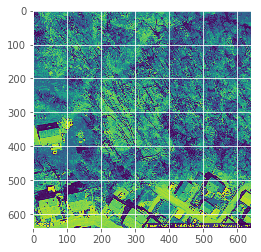

In [8]:
# Start Test Code
img_path = os.path.join("../Image/")

im_pitts_0 = Image.open(img_path+df_img.ImageName[0])
print im_pitts_0.format, im_pitts_0.size, im_pitts_0.mode
plot_image(im_pitts_0)

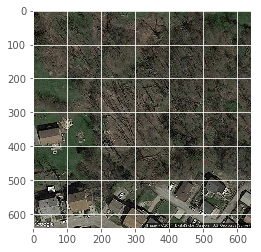

In [9]:
plot_image(im_pitts_0.convert('RGB'))
# End Test Code

# Classification Labels

In this section, we generate the target label i.e. Bins (size = 40) of income for classification. 

In [10]:
def income_to_bins(df, n):
    """ Converts income value into bins of size n
        Args: 
            df : the image dataframe
            n : number of bins
        Returns: 
            df : image df with additional column having bins of median_income
    """
    bins = np.histogram(df.MEDIAN_INCOME, bins=(n-1))[1]
    df['INCOME_BIN'] = [int(np.digitize(df.MEDIAN_INCOME[i],bins))-1 for i in range(len(df))]
    return df

In [11]:
df_img = income_to_bins(df_img,40)

In [12]:
df_img.head()

ImageName        Lat       Long                GEOID  \
0  Pittsburgh00182.png  40.499737 -80.015609  15000US420032612001   
1  Pittsburgh00316.png  40.498437 -80.017309  15000US420032612001   
2  Pittsburgh00317.png  40.498437 -80.015609  15000US420032612001   
3  Pittsburgh00318.png  40.498437 -80.013909  15000US420032612001   
4  Pittsburgh00319.png  40.498437 -80.012209  15000US420032612001   

   MEDIAN_INCOME  INCOME_BIN  
0        56691.0          12  
1        56691.0          12  
2        56691.0          12  
3        56691.0          12  
4        56691.0          12

In [13]:
min(df_img.INCOME_BIN.values), max(df_img.INCOME_BIN.values)

(0, 39)

In [15]:
# # Discard images that do not belong to Pittsburgh 
# import shutil
# import os

# source = '../Image/'
# # source = '../Satellite_Image'

# imgs = list(df_img.ImageName)

# files = os.listdir(source)

# count = 0
# for f in files:
#     if f in imgs:
#         count+=1
#         shutil.move(source+f, dest)
#         if (count % 500 == 0):
#             print count

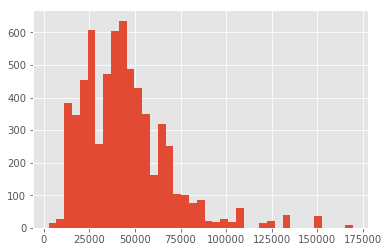

In [16]:
df_img.MEDIAN_INCOME.hist(bins=39)

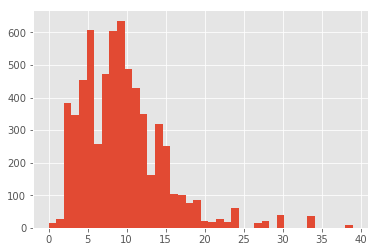

In [17]:
df_img.INCOME_BIN.hist(bins=40)

# Image Pre-processing

All the images are of size 640x640. Although the images are all of same resolution, we further slice the image into 9 equal portions.

- 3x3 split ~= 213x213 size


In [18]:
import math

def split_image(im, n):
    """ Splits (640x640) image into n parts. 
        Args: 
            im (PIL Image) : image object to split
            n : number of splits
        Returns: 
            im_splits : list of n image objects (PIL Image)
    """
    
    l = im.size[0]
    h = im.size[1]
    
    parts = int(math.sqrt(n))
    dist = l/parts

    im_splits = []
    for i in range(parts):
        for j in range(parts):
            im_splits.append(im.crop((j*dist, i*dist, (j+1)*dist, (i+1)*dist)))
            
    return im_splits

In [19]:
# Start Test Code
im_list = split_image(im_pitts_0.convert('RGB'), 9)
len(im_list)

9

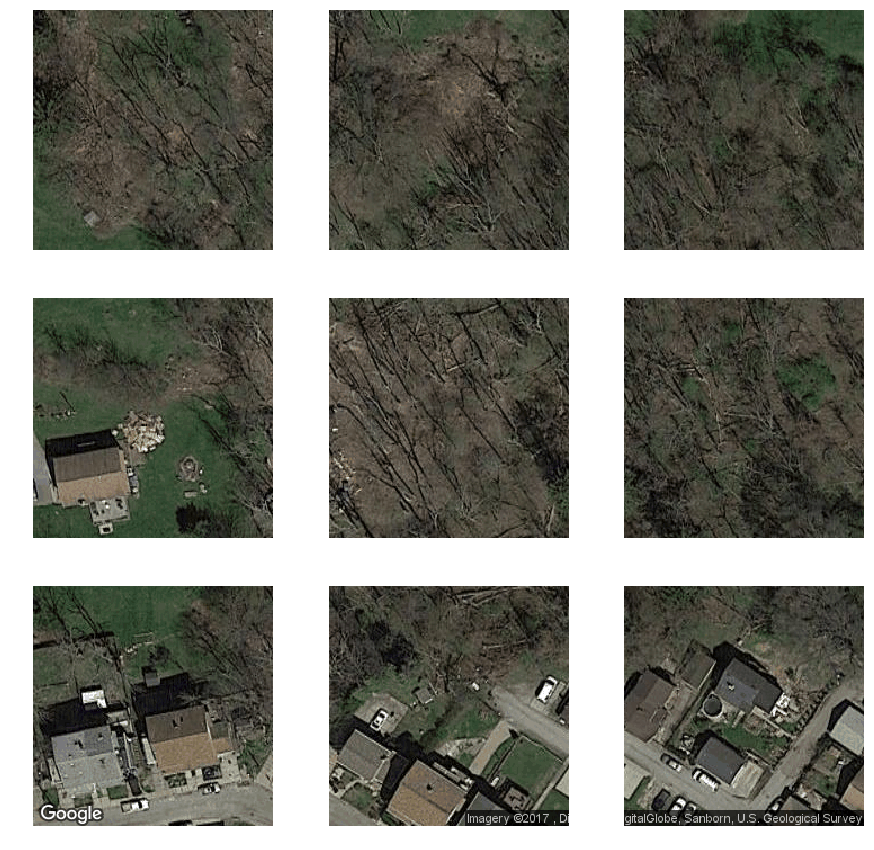

In [20]:
plt.figure(figsize=(15,15))
for i in range(len(im_list)):
    plt.subplot(3,3,i+1)
    plt.axis('off')
    plot_image(im_list[i])
# End Test Code

### Note:
As seen in the above grid, 5/9 images have just trees and they would be clasified with median income of $50k as well. An alternative approach would be to scale down the original image from 640x640 to 100x100 or 200x200 size.

#### Scale function isn't implemented in this code.

In [21]:
def scale_image(im):
    """ Scales a given image. 
        Args: 
            im (PIL Image) : image object to be scaled
        Returns: 
            (PIL Image) : scaled image object
    """
    return im.resize((224,224),Image.ANTIALIAS)

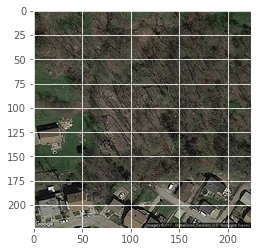

In [22]:
# Start Test Code
plot_image(scale_image(im_pitts_0.convert('RGB')))
# End Test Code

# Train / Validate / Test splits for large datasets

In [23]:
imagefiles = os.listdir(img_path)

im_paths = np.array([img_path+fname for fname in df_img.ImageName])
P = np.random.permutation(len(im_paths))

split = len(P)/3
fnames_tr, fnames_va, fnames_te = im_paths[P[:split]], im_paths[P[split:2*split]], im_paths[P[2*split:]]

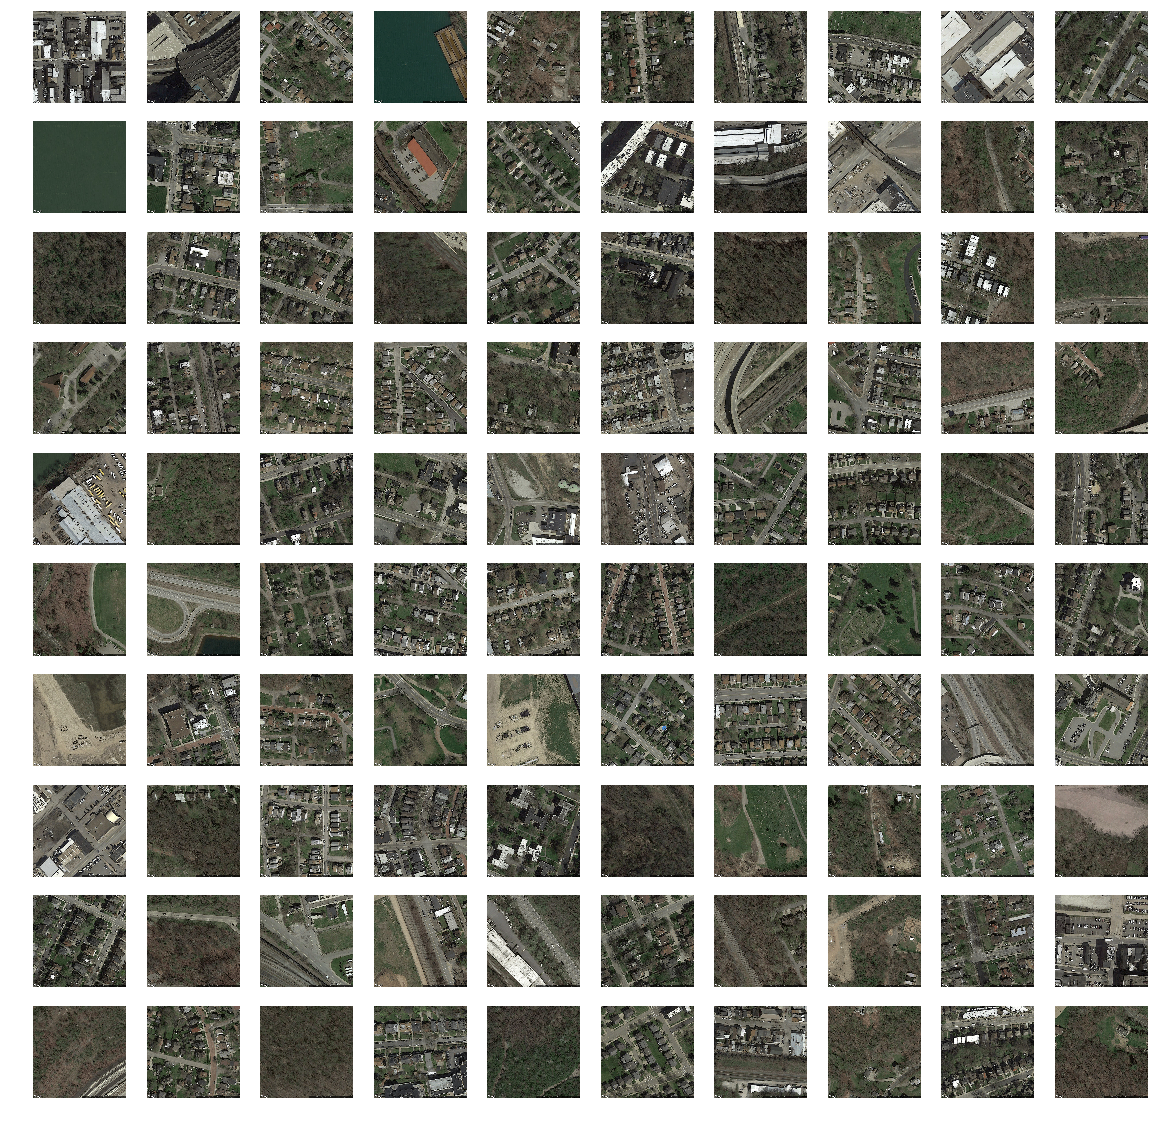

In [24]:
# Start Test Code
plt.figure(figsize=(20,20))
for i,fname in enumerate(fnames_tr[:100]):
    plt.subplot(10,10,i+1)
    plt.axis('off')
    plot_image(Image.open(fname).convert('RGB'))
# End Test Code

- Generate the image data matrix that is to be input into VGG

In [25]:
def map_fname_to_income(img, n):
    """ Replicates the income value n times for n splits of the same image
        Args: 
            img (string) : the image filename
            n : number of splits of image
        Returns: 
            label (list) : list of income_bin
    """
    df_img_input = pd.DataFrame()
    idx = df_img[df_img.ImageName==img].index
    label = [df_img.loc[idx[0],'INCOME_BIN']]*n
    return label
    
def fname_to_vgg_input(fname,n):
    """ Creates the input for a VGG network from the filename 
        Args: 
            fname (string) : the filename to be parsed
            n : number of splits of image
        Returns: 
            list of (numpy ndarray) : a list of n arrays to be passed into the VGG network
    """    
    im = Image.open(fname).convert('RGB')
    
    if n > 1:
        im = split_image(im, n)
        img_array = []
        for idx, img in enumerate(im):
            img_array.append(np.rollaxis(np.array(img),2))
    else:
        im = scale_image(im)
        img_array = np.rollaxis(np.array(im),2)
    return img_array

In [26]:
# Start Test Code
for i in df_img.iterrows():
    img = i[1]['ImageName']
    fname = "../Image/{}".format(img)
    print "Median Income Bin for image" , img, ":", map_fname_to_income(img,1)
    vgg_input = fname_to_vgg_input(fname, 1)
    print "vgg_input: 1 /",len(vgg_input), "=", vgg_input[0]
    print type(vgg_input)
    break 
# End Test Code

Median Income Bin for image Pittsburgh00182.png : [12]
vgg_input: 1 / 3 = [[ 20  17  17 ...,  52  54  60]
 [ 23  35  42 ...,  50  49  59]
 [ 23  33  38 ...,  51  48  58]
 ..., 
 [142 153 113 ...,  62  77  15]
 [142 130 135 ...,  49  54   0]
 [122 126 124 ...,  24  14   4]]
<type 'numpy.ndarray'>


# VGG

In this section, we use a pre-trained VGG-16 network model to generate the image features. We use the weights file `vgg16_weights.h5` downloaded from https://gist.github.com/baraldilorenzo/07d7802847aaad0a35d3.

We load the VGG model from the weights, and construct a new network with the same weights but without the last two dense and dropout layers. 

In [27]:
import keras
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD

def VGG_16(weights_path=None):
    """ Loads a pretrained VGG network without its dense layers. 
        Args: 
            weights_path (string) : the path to the weights file containing the pretrained weights
        Returns: 
            (keras model) : the VGG-16 model without its dense layers
    """
    
    original_vgg, truncated_vgg = Sequential(), Sequential()
    
    for model, size in zip([original_vgg, truncated_vgg], [244,224]):
        model.add(ZeroPadding2D((1,1),input_shape=(3,size,size)))
        model.add(Convolution2D(64, 3, 3, activation='relu'))
        model.add(ZeroPadding2D((1,1)))
        model.add(Convolution2D(64, 3, 3, activation='relu'))
        model.add(MaxPooling2D((2,2), strides=(2,2)))

        model.add(ZeroPadding2D((1,1)))
        model.add(Convolution2D(128, 3, 3, activation='relu'))
        model.add(ZeroPadding2D((1,1)))
        model.add(Convolution2D(128, 3, 3, activation='relu'))
        model.add(MaxPooling2D((2,2), strides=(2,2)))

        model.add(ZeroPadding2D((1,1)))
        model.add(Convolution2D(256, 3, 3, activation='relu'))
        model.add(ZeroPadding2D((1,1)))
        model.add(Convolution2D(256, 3, 3, activation='relu'))
        model.add(ZeroPadding2D((1,1)))
        model.add(Convolution2D(256, 3, 3, activation='relu'))
        model.add(MaxPooling2D((2,2), strides=(2,2)))

        model.add(ZeroPadding2D((1,1)))
        model.add(Convolution2D(512, 3, 3, activation='relu'))
        model.add(ZeroPadding2D((1,1)))
        model.add(Convolution2D(512, 3, 3, activation='relu'))
        model.add(ZeroPadding2D((1,1)))
        model.add(Convolution2D(512, 3, 3, activation='relu'))
        model.add(MaxPooling2D((2,2), strides=(2,2)))

        model.add(ZeroPadding2D((1,1)))
        model.add(Convolution2D(512, 3, 3, activation='relu'))
        model.add(ZeroPadding2D((1,1)))
        model.add(Convolution2D(512, 3, 3, activation='relu'))
        model.add(ZeroPadding2D((1,1)))
        model.add(Convolution2D(512, 3, 3, activation='relu'))
        model.add(MaxPooling2D((2,2), strides=(2,2)))
        model.add(Flatten())
        
        if size == 244:
            model.add(Dense(4096, activation='relu'))
            model.add(Dropout(0.5))
            model.add(Dense(4096, activation='relu'))
            model.add(Dropout(0.5))
            model.add(Dense(1000, activation='softmax'))
            
    if weights_path:
        original_vgg.load_weights(weights_path)
    
    k = len(truncated_vgg.layers)
    for l0, l1 in zip(original_vgg.layers[:k], truncated_vgg.layers):
        l1.set_weights(l0.get_weights())
        
    return truncated_vgg

Using Theano backend.


In [28]:
truncated_vgg = VGG_16("vgg16_weights.h5")

C:\Users\Nikhil\Anaconda2\lib\site-packages\keras\backend\theano_backend.py:1500: UserWarning: DEPRECATION: the 'ds' parameter is not going to exist anymore as it is going to be replaced by the parameter 'ws'.
  mode='max')
C:\Users\Nikhil\Anaconda2\lib\site-packages\keras\backend\theano_backend.py:1500: UserWarning: DEPRECATION: the 'st' parameter is not going to exist anymore as it is going to be replaced by the parameter 'stride'.
  mode='max')
C:\Users\Nikhil\Anaconda2\lib\site-packages\keras\backend\theano_backend.py:1500: UserWarning: DEPRECATION: the 'padding' parameter is not going to exist anymore as it is going to be replaced by the parameter 'pad'.
  mode='max')


# Feature Generation

In this section, we transform the images into features. The features are the flattened output of the last pooling layer of the VGG network.

In [29]:
def fnames_to_features(fnames, vgg):
    """ Given a list of filenames and a VGG16 model, generate the corresponding array of VGG features
        Args: 
            fnames (list) : A list of filenames
            vgg (keras model) : a pretrained VGG16 model
        Returns: 
            (numpy ndarray) : a 2D array of features generated from the VGG model
    """         
    vgg_input = []
#     [vgg_input.extend(fname_to_vgg_input(f, 9)) for f in fnames]
    [vgg_input.append(fname_to_vgg_input(f, 1)) for f in fnames]
    vgg_input = np.asarray(vgg_input)
    return vgg.predict(vgg_input, verbose = 1)

In [30]:
import time

In [31]:
# Generate VGG features for Training set
start = time.time()
X_tr = fnames_to_features(fnames_tr, truncated_vgg) 
end = time.time()
print "Finished generating VGG features for Training set in {} minutes".format((end-start)/60.0)

2145/2145 [==============================] - 1509s  
Finished generating VGG features for Training set in 25.8141333342 minutes


In [32]:
# Generate VGG features for Validation set
start = time.time()
X_va = fnames_to_features(fnames_va, truncated_vgg)
end = time.time()
print "Finished generating VGG features for Validation set in {} minutes".format((end-start)/60.0)

2145/2145 [==============================] - 1197s  
Finished generating VGG features for Validation set in 20.6158333341 minutes


In [33]:
# Generate VGG features for Test set
start = time.time()
X_te = fnames_to_features(fnames_te, truncated_vgg)
end = time.time()
print "Finished generating VGG features for Test set in {} minutes".format((end-start)/60.0)

2145/2145 [==============================] - 1063s  
Finished generating VGG features for Test set in 18.2434333324 minutes


In [34]:
import bcolz

def save_array(fname, arr): c=bcolz.carray(arr, rootdir=fname, mode='w'); c.flush()
def load_array(fname): return bcolz.open(fname)[:]

In [48]:
# Save X_tr
fname = 'features/training/'

start = time.time()
save_array(fname, X_tr)
end = time.time()
print "Finished saving VGG features for Training set in {} minutes".format((end-start)/60.0)

Finished saving VGG features for Training set in 0.0263333320618 minutes


In [49]:
# Save X_va
fname = 'features/validation/'

start = time.time()
save_array(fname, X_va)
end = time.time()
print "Finished saving VGG features for Validation set in {} minutes".format((end-start)/60.0)

Finished saving VGG features for Validation set in 0.0245333313942 minutes


In [50]:
# Save X_te
fname = 'features/testing/'

start = time.time()
save_array(fname, X_te)
end = time.time()
print "Finished saving VGG features for Test set in {} minutes".format((end-start)/60.0)

Finished saving VGG features for Test set in 0.0257333318392 minutes


In [51]:
print X_te.shape, X_va.shape, X_tr.shape

(2145L, 25088L) (2145L, 25088L) (2145L, 25088L)


In [52]:
# Load X_tr
fname = 'features/training/'

start = time.time()
X_tr = load_array(fname)
end = time.time()
print "Finished loading VGG features for Training set in {} minutes".format((end-start)/60.0)

Finished loading VGG features for Training set in 0.00573333104451 minutes


In [53]:
# Load X_va
fname = 'features/validation/'

start = time.time()
X_va = load_array(fname)
end = time.time()
print "Finished loading VGG features for Validation set in {} minutes".format((end-start)/60.0)

Finished loading VGG features for Validation set in 0.00593333244324 minutes


In [54]:
# Load X_te
fname = 'features/testing/'

start = time.time()
X_te = load_array(fname)
end = time.time()
print "Finished loading VGG features for Test set in {} minutes".format((end-start)/60.0)

Finished loading VGG features for Test set in 0.00601666768392 minutes


In [55]:
print X_te.shape, X_va.shape, X_tr.shape

(2145L, 25088L) (2145L, 25088L) (2145L, 25088L)


In [56]:
# Get corresponding income bin for Training set 
y_tr = []
for f in fnames_tr:
    y_tr.extend(map_fname_to_income(f[9:], 1))
y_tr = np.asarray(y_tr)

In [57]:
# Get corresponding income bin for Validation set 
y_va = []
for f in fnames_va:
    y_va.extend(map_fname_to_income(f[9:], 1))
y_va = np.asarray(y_va)

In [58]:
# Get corresponding income bin for Test set 
y_te = []
for f in fnames_te:
    y_te.extend(map_fname_to_income(f[9:], 1))
y_te = np.asarray(y_te)

In [59]:
print y_tr.shape, y_va.shape, y_te.shape

(2145L,) (2145L,) (2145L,)


# Classification

In this section, we classify the images into bins of income levels. We use the training set and validation set to tune the model. The performance of the model is then tested against the testing set.

In [67]:
def predict_from_features(X, y, X_te):
    """ Given labels and VGG features, predict the income bin of the testing set. 
    Args: 
        X (numpy ndarray) : 2D array of VGG features, each row is a set of features for a single example
        y (numpy ndarray) : 1D array of labels corresponding to the features in X
        X_te (numpy ndarray) : 2D array of VGG features for unlabeled examples
    Returns: 
        (numpy ndarray) 1D array of predicted labels for the unlabeled examples in X_te
    """
    model = Sequential()
    model.add(Dense(100, input_dim = X.shape[1], activation = 'relu', init = "uniform"))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation = 'relu', init = 'uniform'))
    model.add(Dense(40, activation = 'softmax', init = 'uniform'))
    model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    model.fit(X, np.eye(40)[y,:], nb_epoch = 5,  batch_size = 10)
    y_ohe = model.predict(X_te)
    return np.argmax(y_ohe, axis = 1)
# print validation accuracies

In [63]:
print len(X_tr), len(X_va), len(X_te)

2145 2145 2145


# Testing

In [68]:
import time
# Validation
start = time.time()
y_p = predict_from_features(X_tr, y_tr, X_va)
end = time.time()
print "Validation accuracy: {} in {} seconds".format(np.mean(y_p==y_va), end-start)


Epoch 1/5
2145/2145 [==============================] - 10s - loss: 3.3306 - acc: 0.0956    
Epoch 2/5
2145/2145 [==============================] - 10s - loss: 3.0788 - acc: 0.1110    
Epoch 3/5
2145/2145 [==============================] - 10s - loss: 2.9687 - acc: 0.1305    
Epoch 4/5
2145/2145 [==============================] - 22s - loss: 2.8547 - acc: 0.1221    
Epoch 5/5
2145/2145 [==============================] - 25s - loss: 2.8703 - acc: 0.1375    
Validation accuracy: 0.0979020979021 in 79.2849998474 seconds


In [69]:
# Merge the training and validation set as the input for the final model
X_in = np.append(X_tr, X_va, axis = 0)
y_in = np.append(y_tr, y_va)

In [70]:
# Test final model 
start = time.time()
y_p = predict_from_features(X_in, y_in, X_te)
end = time.time()
print "Test accuracy: {} in {} seconds".format(np.mean(y_p==y_te), end-start)

Epoch 1/5
4290/4290 [==============================] - 19s - loss: 3.1789 - acc: 0.0879    
Epoch 2/5
4290/4290 [==============================] - 34s - loss: 2.9447 - acc: 0.1166    
Epoch 3/5
4290/4290 [==============================] - 55s - loss: 2.8769 - acc: 0.1224    
Epoch 4/5
4290/4290 [==============================] - 62s - loss: 2.8124 - acc: 0.1368    
Epoch 5/5
4290/4290 [==============================] - 67s - loss: 2.7866 - acc: 0.1368    
Test accuracy: 0.117948717949 in 241.282000065 seconds
